## Comparación de modelos

En esta sesión de prácticas vamos a realizar comparaciones entre predictores en diferentes situaciones. 

### 1. Dos clasificadores en un dominio

#### 1.1. Caso paramétrico
Para un determinado conjunto de datos se han probado dos clasificadores: árbol C50 y redes neuronales. Cada clasificares se han evaluado utilizando una validación cruzada con 10 pliegues. En el fichero ejemplo1.dat puedes encontrar el índice Kappa para cada uno de los 10 pliegues. Con estos datos ¿qué podemos decir sobre la eficacia de dichos clasificadores?

In [1]:
import pandas as pd
import numpy as np


In [2]:
ej1 = pd.read_csv('./data/ejemplo1.dat')
display(ej1)

,nnet,C50
0,0.814815,0.666667
1,0.589744,0.764706
2,0.600000,0.818182
3,0.179487,0.294118
4,0.814815,1.000000
5,0.000000,-0.111111
6,0.000000,0.333333
7,0.764706,0.764706
8,0.818182,0.818182
9,0.000000,-0.111111


In [3]:
ej1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   nnet    10 non-null     float64
 1   C50     10 non-null     float64
dtypes: float64(2)
memory usage: 292.0 bytes


Como podemos observar estamos comparando dos clasificadores en un dominio, por lo tanto, primero deberíamos comprobar si se cumplen las condiciones para realizar un test T de Student con medidas pareadas: normalidad y homogeneidad de las varianzas (homocedasticidad). 

Para comprobar la normalidad podemos utilizar dos test: el test de Shapiro-Wilk y el test de Kolmogorov-Smirnov con la corrección Lilliefors. El test de Shapiro-Wilk se recomienda cuando el número de muestras es menor a 50, mientras que el test de Kolmogorov-Smirnov con la corrección Lilliefors se recomienda cuando las muestras son mayores a 50. 


Test de Shapiro-Wilk

- Qué hace: Este test evalúa la hipótesis de que una muestra proviene de una población normalmente distribuida. Calcula un estadístico WW basado en la correlación entre los datos observados y los valores esperados bajo una distribución normal. Un valor de WW cercano a 1 indica que la muestra podría provenir de una distribución normal.

- Por qué se usa: El test de Shapiro-Wilk es particularmente eficaz para muestras pequeñas, generalmente recomendado para muestras con menos de 50 observaciones. Esto se debe a su alta potencia para detectar desviaciones de la normalidad en muestras pequeñas, lo que lo hace más confiable que otros test en estos contextos.

Test de Kolmogorov-Smirnov con la corrección de Lilliefors

- Qué hace: El test de Kolmogorov-Smirnov es un test no paramétrico que compara la distribución acumulada de una muestra con una distribución teórica esperada, en este caso, la normal. La corrección de Lilliefors modifica el test de Kolmogorov-Smirnov para mejorar su capacidad de evaluar la normalidad cuando los parámetros de la distribución normal (media y desviación estándar) se estiman a partir de los datos, en lugar de ser conocidos a priori.

- Por qué se usa: Este test, con la corrección de Lilliefors, se recomienda para muestras más grandes, típicamente mayores a 50 observaciones. En muestras grandes, el impacto de estimar los parámetros de la distribución disminuye, y este test proporciona una buena mezcla de sensibilidad y especificidad para detectar desviaciones de la normalidad. Además, para muestras grandes, el test de Shapiro-Wilk puede perder potencia y ser menos efectivo para identificar no normalidad.
    

En este caso, aunque sólo tenemos 10 muestras vamos a realizar ambos test para aclarar cómo se aplican. Recordad que la normalidad hay que comprobarla sobre las diferencias entre las medidas obtenidas en cada pliegue, ya que lo que queremos comprobar es si existen diferencias significativas entre las medias del rendimiento entre las dos clasificadores. En nuestro caso el test intenta comprobar estas hipótesis:

$$ H_0: X \sim N(\mu, \sigma^2) $$
$$ H_1: X \nsim N(\mu, \sigma^2) $$

In [4]:
from scipy.stats import shapiro
s, p = shapiro(ej1['nnet'] - ej1['C50'])
print('### Shapiro-Wilk normality test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Shapiro-Wilk normality test
### statistic = 0.9353, p-value = 0.5018


In [5]:
from statsmodels.stats.diagnostic import lilliefors
s, p = lilliefors(ej1['nnet'] - ej1['C50'], dist='norm', pvalmethod='table')
print('### Lilliefors (Kolmogorov-Smirnov) normality test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))


### Lilliefors (Kolmogorov-Smirnov) normality test
### statistic = 0.1602, p-value = 0.6573


Como podemos ver, no podemos rechazar la hipótesis nula de que la muestra procede de una distribución normal, con un 95% de confianza (W=0.935, p-value=0.502 y D=0.16, p-value=0.661). En este caso sólo nos habría hecho falta aplicar el test de Shapiro-Wilk al ser la muestra menor que 50.

Una vez comprobada la normalidad, hay que proceder con la comprobación de la homocedasticidad (homogeneidad de las varianzas). Para ello tenemos dos test: el test de Levene y el test de Bartlett. Este último es más potente en el caso de que se pueda asumir la normalidad, como es nuestro caso.

**Distribución Normal**

Se refiere a la suposición de que los datos, o los residuos en el contexto de la regresión, siguen una distribución normal. Es decir, la mayoría de los datos se concentra alrededor de la media, y hay una simetría en la distribución de los datos hacia los extremos (las colas). Esta característica es importante porque muchos tests estadísticos asumen que los datos siguen esta distribución para calcular la significancia de los resultados.

**Homocedasticidad (Homogeneidad de las Varianzas)**

La homocedasticidad, por otro lado, se refiere a la suposición de que las varianzas a lo largo de las diferentes muestras o grupos son iguales. Esto es crucial en análisis donde se comparan grupos, como el ANOVA, ya que una varianza desigual (heterocedasticidad) puede sesgar los resultados y llevar a conclusiones erróneas.
Evaluación de la Homocedasticidad

Una vez establecido que una muestra sigue una distribución normal, el siguiente paso es evaluar la homocedasticidad antes de proceder con análisis que asumen tanto la normalidad como la igualdad de varianzas. Los tests más comunes para evaluar la homocedasticidad son:

- Test de Levene

    - Qué hace: Evalúa si las varianzas de dos o más grupos son iguales. No asume que los datos siguen una distribución normal, lo que lo hace más robusto frente a desviaciones de la normalidad.

    - Cuándo usarlo: Es preferible cuando no estás completamente seguro de la normalidad de los datos o cuando hay evidencia de que los datos podrían no seguir una distribución normal.

- Test de Bartlett

    - Qué hace: Similar al test de Levene, el test de Bartlett evalúa la igualdad de varianzas entre grupos. Sin embargo, asume que los datos siguen una distribución normal, lo que puede hacerlo más sensible en esos contextos.

    - Cuándo usarlo: Es más potente que el test de Levene cuando los datos siguen una distribución normal, como indicas en tu situación. Por lo tanto, es la opción preferida en casos donde la normalidad está asegurada.

In [6]:
from scipy.stats import levene
s, p = levene(ej1['nnet'], ej1['C50'], center='median')
print('### Levene\'s Test for Homogeneity of Variance (center = median)')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Levene's Test for Homogeneity of Variance (center = median)
### statistic = 0.0017, p-value = 0.9672


In [7]:
from scipy.stats import bartlett
s, p = bartlett(ej1['nnet'], ej1['C50'])
print('### Bartlett test of homogeneity of variances')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Bartlett test of homogeneity of variances
### statistic = 0.0530, p-value = 0.8179


Como podemos ver, los dos test confirman al 95% que no podemos rechazar la hipótesis de que las varianzas en las medidas obtenidas en cada clasificador son homogéneas (L=0.002, p-value=0.967 > 0.05 y B=0.053, p-value=0.818 > 0.05).

Al cumplirse las condiciones de aplicabilidad del test T de Student con medidas pareadas, podemos comprobar si las diferencias detectadas en los clasificadores es significativa o no. Es decir, las hipótesis que intenta comprobar el test se pueden expresar de la siguiente manera:

$$ H_0: \mu_{C50} − \mu_{nnet} = 0 $$
$$ H_q: \mu_{C50} − \mu_{nnet} \neq 0 $$

In [8]:
from scipy.stats import ttest_rel
s, p = ttest_rel(ej1['nnet'], ej1['C50'])
print('### Paired t-test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

from scipy.stats import t
alpha = 0.05  # nivel de significancia
df = 9  # grados de libertad
v = t.ppf(1 - alpha/2, df)
print('### t-{}-{:.3f} = {:.4f}'.format(df, 1-alpha/2, v))

### Paired t-test
### statistic = -1.2692, p-value = 0.2362
### t-9-0.975 = 2.2622


Atendiendo a los resultados del test, podemos concluir que con el 95% de confianza las diferencias entre las medias obtenidas por cada clasificador no son significativas (no podemos rechazar la hipótesis de que la diferencias entre las medias sea 0). Es decir, no existen diferencias significativas entre los dos clasificadores con el conjunto de datos utilizado ($|T|$= 1.269 < $T_{9,0.975}$, p-value = 0.236). 

En este caso, se podría haber aplicado un test t de Student para una muestra, con la diferencia de medias obtenida en cada pliegue:

In [9]:
from scipy.stats import ttest_1samp
s, p = ttest_1samp(ej1['nnet'] - ej1['C50'], popmean=0)
print('### One Sample t-test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### One Sample t-test
### statistic = -1.2692, p-value = 0.2362


#### 1.2. Caso no paramétrico

Un caso no paramétrico se refiere a métodos estadísticos que no asumen una forma específica (paramétrica) para la distribución de los datos. A diferencia de los métodos paramétricos, que se basan en suposiciones sobre la distribución subyacente de los datos (como asumir una distribución normal), los métodos no paramétricos son más flexibles ya que no requieren tales suposiciones. Esto los hace particularmente útiles para analizar datos que no cumplen con los supuestos de los métodos paramétricos, como la normalidad o la homogeneidad de varianzas.

**Características de los Métodos No Paramétricos**

- Flexibilidad: Pueden ser aplicados a datos que no siguen una distribución conocida o específica, lo que los hace útiles en una amplia gama de situaciones.

- Robustez: Son menos sensibles a outliers o a desviaciones de las suposiciones de distribución, lo que puede proporcionar resultados más fiables en presencia de datos anómalos.

- Aplicabilidad: Pueden ser usados con datos ordinales (donde las observaciones pueden ser ordenadas pero no necesariamente cuantificadas exactamente) y datos nominales, además de datos numéricos.

**Ejemplos de Métodos No Paramétricos**

- Test de Mann-Whitney U: Usado para comparar las diferencias entre dos grupos independientes cuando no se puede asumir la normalidad de las distribuciones.
    
- Test de Wilcoxon de rangos con signo: Utilizado para comparar dos muestras relacionadas, pareadas o medidas repetidas en una misma muestra para evaluar si sus poblaciones medias difieren.
    
- Test de Kruskal-Wallis: Una extensión del test de Mann-Whitney para comparar más de dos grupos independientes.
    
- Test de Friedman: Usado para comparar más de dos grupos relacionados o medidas repetidas, similar a la ANOVA pero para datos que no cumplen los supuestos paramétricos.

- Test de Chi-cuadrado: Utilizado para comparar proporciones o frecuencias observadas con las esperadas en categorías nominales.

Cuándo Usar Métodos No Paramétricos

Se prefieren los métodos no paramétricos cuando:

   - Los datos no se distribuyen normalmente.
   - Los datos son ordinales o nominales.
   - Las muestras son pequeñas.
   - Hay presencia significativa de outliers.
    

Supongamos ahora que queremos comprobar como se comportan un clasificador de máquina de soporte de vectores (SMV) y un análisis lineal discriminante (LDA) sobre un determinado conjunto de datos. Una vez entrenados, los clasificadores se han evaluado mediante una validación cruzada con 10 pliegues. En el fichero ejemplo2.dat se pueden encontrar los valores para la precisión para cada uno de los pliegues:

In [10]:
ej2 = pd.read_csv('data/ejemplo2.dat')
ej2.head(10)

,SVM,LDA
0,0.933333,0.933333
1,0.875000,0.875000
2,0.812500,0.875000
3,0.812500,0.875000
4,0.933333,0.933333
5,0.800000,0.800000
6,0.600000,0.533333
7,0.937500,0.937500
8,0.750000,0.937500
9,0.800000,0.733333


In [11]:
ej2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SVM     10 non-null     float64
 1   LDA     10 non-null     float64
dtypes: float64(2)
memory usage: 292.0 bytes


Ahora volvemos a comprobar las condiciones de aplicabilidad del test t de Student con medidas pareadas. Primero comprobamos la normalidad de la muestra:

In [12]:
s, p = shapiro(ej2['SVM'] - ej2['LDA'])
print('### Shapiro-Wilk normality test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Shapiro-Wilk normality test
### statistic = 0.8363, p-value = 0.0399


Como podemos afirmar que las muestras no proceden de una distribución normal con el 95% de confianza (W= 0.836, p-value= 0.04). Mas formalmente, podemos rechazar la hipótesis nula de que la muestra no proviene de una distribución normal. Por lo tanto, no podemos aplicar el test t de Student para muestras pareadas (o su versión para una muestra). En este caso tenemos que aplicar los test no paramétricos como el test de McNemar o el test de la suma de rangos de Wilcoxon para muestras pareadas.

Empecemos por el test de McNemar, que necesita como datos la matriz de confusión para los dos métodos considerados. Esta matriz se encuentra en el siguiente fichero:

In [13]:
matriz = pd.read_csv('data/matrizConfEjemplo2.dat')
print(matriz)

  Unnamed: 0  FALLECE  VIVE
0    FALLECE       31    11
1       VIVE       17   136


Recordemos que el test de McNemar comprueba si las proporciones de error son iguales, es decir:
$$ H_0: p_{FP}=p_{FN} $$
$$ H_1: p_{FP} \neq p_{FN} $$

In [14]:
from statsmodels.stats.contingency_tables import mcnemar
r = mcnemar(matriz.to_numpy()[:, 1:3], exact=False, correction=True)  # exact a falso para usar Chi-cuadrado, sino dist. binomial
print('### McNemar\'s Chi-squared test with continuity correction')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(r.statistic, r.pvalue))

### McNemar's Chi-squared test with continuity correction
### statistic = 0.8929, p-value = 0.3447


En este caso podemos afirmar con el 95% de confianza que las proporciones de error no muestran diferencias significativas ($χ^2$=0.893, p-value= 0.345). Es decir, no se aprecian diferencias significativas entre los modelos.

El test de Wilcoxon comparará las medianes de las dos muestras en vez de las medias. Es decir, las hipótesis que se quieren comprobar se pueden expresar de la siguiente manera:

$$ H0: \eta_{SVM} = \eta_{LDA} $$
$$ H1: \eta_{SVM} \neq \eta_{LDA} $$

In [15]:
from scipy.stats import wilcoxon
s, p = wilcoxon(ej2['SVM'], ej2['LDA'])
print('### Wilcoxon signed rank test with continuity correction')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Wilcoxon signed rank test with continuity correction
### statistic = 7.0000, p-value = 0.8923


/home/alourido/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/alourido/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


En este caso, como podemos apreciar, las advertencias nos están indicado que no se pueden calcular el p-value exacto debido a que se producen empates entre las dos muestras. En esta situación deberíamos utilizar la función wilcox_test() del paquete coin que corrige este efecto.

In [16]:
from scipy.stats import mannwhitneyu
s, p = mannwhitneyu(ej2['SVM'], ej2['LDA'])
print('### Asymptotic Wilcoxon-Mann-Whitney Test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Asymptotic Wilcoxon-Mann-Whitney Test
### statistic = 41.5000, p-value = 0.5409


Analizando los resultados, podemos afirmar que no podemos rechazar la hipótesis nula de que las medianas de las muestras sean iguales con un 95% de confianza (Z= 41.5, p-vaue= 0.516). Es decir, la diferencia entre los dos modelos no son estadísticamente significativas.

### 2. Dos predictores en múltiples dominios

En este ejemplo, dos predictores se han utilizado utilizando 10 conjuntos de datos. Concretamente, se ha calculado la precisión de una máquina de soporte de vectores (SVM) con kernel lineal y un árbol C50 en cada uno de los 10 conjuntos de datos. En la siguiente tabla se puede ver el resultado en cada uno de los conjunto de datos:

In [17]:
ej3 = pd.read_csv('data/ejemplo3.dat')
ej3.head(10)

,Unnamed: 0,SVMLinear,C50
0,hepatitis,0.844167,0.862917
1,iris,0.960000,0.946667
2,cox2,0.805042,0.835291
3,oil,0.969167,0.959798
4,dhfr,0.926136,0.910701
5,German,0.747000,0.756000
6,Seg,0.803320,0.845929
7,Breast,0.964244,0.961407
8,Pima,0.773445,0.757861
9,Sonar,0.745606,0.832078


En este caso estamos comparando dos clasificadores en múltiples dominios. La recomendación es utilizar el test de la suma de rangos de Wilcoxon para muestras pareadas (o su versión de una muestra, calculando la diferencia de la precisión obtenida en cada dataset).

In [18]:
s, p = wilcoxon(ej3['SVMLinear'], ej3['C50'])
print('### Wilcoxon signed rank test with continuity correction')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Wilcoxon signed rank test with continuity correction
### statistic = 19.0000, p-value = 0.4316


Se puede afirmar que, con una confianza del 95%, no existen diferencias significativas entre la precisión de los dos clasificadores sobre el conjunto de datos seleccionados (W = 19 > $W_{4,0.05}$, p-value= 0.432 > 0.05).

### 3. Múltiples predictores en múltiples dominios

#### 3.1. Caso paramétrico

Para esta sección vamos a seguir uno de los ejemplos presentados en [1]. En este ejemplo dispones de los datos de precisión de tres clasificadores en 10 conjunto de datos diferentes. El objetivo es determinar si existen diferencias significativas entre los distintos clasificadores en dichos conjunto de datos. Los resultados de entrentar los 3 clasificadores sobre los 10 conjuntos se pueden ver en la siguiente tabla:

In [19]:
ej4 = pd.read_csv('data/ejemplo4.csv')
ej4.columns = ['dataset', 'A', 'B', 'C']
ej4.head(10)

,dataset,A,B,C
0,1,0.8583,0.7586,0.8419
1,2,0.8591,0.7318,0.8590
2,3,0.8612,0.6908,0.8383
3,4,0.8582,0.7405,0.8511
4,5,0.8628,0.7471,0.8638
5,6,0.8642,0.6590,0.8120
6,7,0.8591,0.7625,0.8638
7,8,0.8610,0.7510,0.8675
8,9,0.8595,0.7050,0.8803
9,10,0.8612,0.7395,0.8718


En este caso, al comparar múltiples clasificadores en múltiples dominios, debemos aplicar el test ANOVA de una vía para medidas pareadas o su equivalente no paramétrico, el test de Friedman. 

Antes de aplicar el test, comprobemos de forma descriptiva cómo se distribuyen los datos. Para ello, primero transformaremos el conjunto de datos como sigue: 

In [20]:
ej4_t = pd.DataFrame({
    'Accuracy': pd.concat([ej4['A'], ej4['B'], ej4['C']]),
    'Method': np.repeat(['A', 'B', 'C'], 10),
    'Dataset': pd.concat([ej4['dataset'], ej4['dataset'], ej4['dataset']])
})
ej4_t.head(30)

,Accuracy,Method,Dataset
0,0.8583,A,1
1,0.8591,A,2
2,0.8612,A,3
3,0.8582,A,4
4,0.8628,A,5
5,0.8642,A,6
6,0.8591,A,7
7,0.8610,A,8
8,0.8595,A,9
9,0.8612,A,10


Hagamos primero un análisis descriptivo y gráfico: 

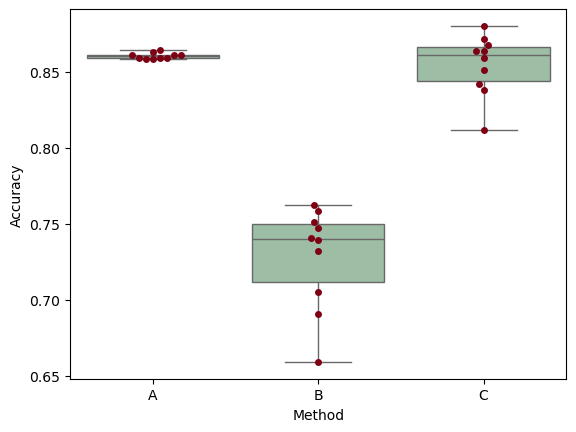

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='Method', y='Accuracy', data=ej4_t, color='#99c2a2')
ax = sns.swarmplot(x='Method', y='Accuracy', data=ej4_t, color='#7d0013')
plt.show()

In [22]:
print('Accuracy media y desviación típica por método:')
ej4_t.groupby('Method')['Accuracy'].agg(['mean', 'std'])

Accuracy media y desviación típica por método:


,mean,std
Method,,
A,0.86046,0.001979
B,0.72858,0.033323
C,0.85495,0.019900


Aunque a simple vista se puede comprobar que no tienen la misma media, realicemos dicha comprobación a través del test de ANNOVA. 
Para ello debemos de comprobar las condiciones de aplicabilidad para el test ANOVA de una vía para medidas pareadas: normalidad y esfericidad (el equivalente a la homocedasticidad para el ANOVA de medidas pareadas).

En el caso del test ANOVA de una vía para medidas pareadas se comprueba si las medias entre los diferentes clasificadores son iguales, es decir:

$$ H0: \mu_1 = \mu_2 = \dots = \mu_n $$
$$ H1: \text{las medias no son iguales} $$

Para la condición de normalidad, debemos comprobar que la muestra de cada uno de los grupos procede de una población con distribución normal. Como hemos comentado anteriormente, esto se puede realizar mediante el test de Shapiro-Wilks:

In [23]:
# Clasificador A
s, p = shapiro(ej4['A'])
print('### Shapiro-Wilk normality test for classifier A')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))
# Clasificador B
s, p = shapiro(ej4['B'])
print('### Shapiro-Wilk normality test for classifier A')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))
# Clasificador C
s, p = shapiro(ej4['C'])
print('### Shapiro-Wilk normality test for classifier A')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Shapiro-Wilk normality test for classifier A
### statistic = 0.9189, p-value = 0.3477
### Shapiro-Wilk normality test for classifier A
### statistic = 0.8741, p-value = 0.1114
### Shapiro-Wilk normality test for classifier A
### statistic = 0.9258, p-value = 0.4083


Como se puede deducir de los datos, las precisiones obtenidas por cada clasificador en cada uno de los conjuntos de datos proceden de una distribución normal con un 95% de confianza (WClassA= 0.919, p-valueClassA= 0.348, WClassB= 0.874, p-valueClassB = 0.111, WClassC= 0.926, p-valueClassC=0.408). 

El siguiente paso es comprobar la homogeneidad de las varianzas, que en el caso de un ANOVA con medidas repetidas se traduce en comprobar la esfericidad de la matriz de covarianzas. 

In [24]:
#pip3 install pingouin

In [25]:
import pingouin as pg
#spher, W, chisq, dof, pval = pg.sphericity(ej4)
spher, W, chisq, dof, pval = pg.sphericity(
    data       = ej4_t,
    dv         = 'Accuracy',
    within     = 'Method',
    subject    = 'Dataset',
    method     = 'mauchly',
    alpha      = 0.05
)
print('Sphericity: {}, statistic: {:.3f}, chi-square-statistic: {:.3f}, degrees-of-freedom: {}, p-value: {:.3f}'.format(
    spher, W, chisq, dof, pval
))

Sphericity: True, statistic: inf, chi-square-statistic: -inf, degrees-of-freedom: 2, p-value: 1.000


/home/alourido/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


Como podemos ver que, con el 95% de confianza, no podemos rechazar la hipótesis nula de que la matriz de covarianzas cumple la propiedad de esfericidad (W=0.574, p-value= 0.511).

También podríamos haber utilizado directamente la función rm_anova() de la misma librería, que nos calcula tanto el test ANOVA para medidas repetidas suponiendo que se cumple la esfericidad, el test de Mauchly y test ANOVA para medidas repetidas con la corrección de p-value para compensar el incumplimiento de la condición de esfericidad, utilizando el Greenhouse-Geisser and Huynh-Feldt epsilon value. En esta función debemos indicar en el parámetro dv la variable dependiente, en el parámetro subject la identificación de las muestras, en nuestro caso las bases de datos y en el parámetro within la variable predictora, en nuestro caso la que define los diferentes modelos que se están comparando.

In [26]:

pg.rm_anova(
    data       = ej4_t,
    dv         = 'Accuracy',
    within     = 'Method',
    subject    = 'Dataset',
    detailed   = True,
    correction = True
)

/home/alourido/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,Method,0.111307,2,0.055653,142.418041,9.259424e-12,2.290742e-09,0.891167,0.757005,True,inf,1.0
1,Error,0.007034,18,0.000391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como se puede apreciar, en primer lugar se nos muestra el resultado del test ANOVA para medidas repetidas suponiendo que se cumple la esfericidad, que nos indica que existen diferencias entre los clasificadores altamente significativas (F=142.418, p-value (p-unc) < 10-4). Las columnas sphericity y p-spher  (p-valor) se corresponden con el test de Mauchly para la esfericidad, que nos indica que no podemos rechazar la hipótesis de que la matriz de covarianzas cumpla esta propiedad. Las columnas eps (Greenhouse-Geisser epsilon factor) y p-GG-corr (p-valor) muestran el resultado de aplicar un procedimiento que permite corregir la desviación producida por cumplir con la esfericidad a los resultados de test ANOVA anteriormente realizados.

Como ya hemos indicado, ahora debemos proceder con el test de Tukey para identificar donde están las diferencias. Para ello vamos a utilizar la función tukeyTest() del paquete PMCMRplus.

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=ej4_t['Accuracy'], groups=ej4_t['Method'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B  -0.1319    0.0 -0.1568 -0.107   True
     A      C  -0.0055 0.8478 -0.0304 0.0194  False
     B      C   0.1264    0.0  0.1015 0.1512   True
---------------------------------------------------


Como se pueden ver en los resultados, existen diferencias altamente significativas entre el clasificador A y el clasificador B (p-value < 10-4) y el entre el B y el C (p-value < 10-4). En ambos casos, los datos estimados para la media de las diferencias indican que, teniendo en cuenta la precisión, el B es peor que el resto de los clasificadores. No podemos establecer diferencias significativas entre el A y el C (Z= -0.777, p-value= 0.848). 

#### 3.2. Caso no paramétrico



Supongamos que queremos comprobar la eficacia de una SVM con kernel lineal, un árbol C5.0 y una red neuronal en diferentes conjuntos de datos. Para ello, hemos entrenado cada uno de los clasificadores en cada uno de los conjuntos de datos obteniendo el índice Kappa en cada evaluación. Los resultados se pueden apreciar en la siguiente tabla:

In [28]:
ej5 = pd.read_csv('data/ejemplo3TablaKappa.csv')
ej5.columns = ['Dataset', 'SVMLinear', 'C50', 'NNET']
ej5.head(10)

,Dataset,SVMLinear,C50,NNET
0,hepatitis,0.458175,0.523767,0.441098
1,iris,0.940000,0.920000,0.950000
2,cox2,0.356839,0.392446,0.427785
3,oil,0.957299,0.946611,0.982979
4,dhfr,0.842190,0.809820,0.843982
5,German,0.357970,0.378608,0.388413
6,Seg,0.567466,0.664388,0.578170
7,Breast,0.920248,0.914644,0.931243
8,Pima,0.476974,0.457351,0.485749
9,Sonar,0.489955,0.661162,0.698528


Como en el caso anterior, tenemos que elegir entre un test ANOVA de una vía para medidas pareadas o su equivalente no paramétrico el test de Friedman, dependiendo si se cumplen los supuestos para el test ANOVA. Como en el caso anterior, resulta más cómodo transformar la tabla, con la información sobre las agrupaciones en una columna.

In [29]:
ej5_t = pd.DataFrame({
    'Kappa': pd.concat([ej5['SVMLinear'], ej5['C50'], ej5['NNET']]),
    'Method': np.repeat(['SVMLinear', 'C50', 'NNET'], 10),
    'Dataset': pd.concat([ej5['Dataset'], ej5['Dataset'], ej5['Dataset']])
})
ej5_t.head(30)

,Kappa,Method,Dataset
0,0.458175,SVMLinear,hepatitis
1,0.940000,SVMLinear,iris
2,0.356839,SVMLinear,cox2
3,0.957299,SVMLinear,oil
4,0.842190,SVMLinear,dhfr
5,0.357970,SVMLinear,German
6,0.567466,SVMLinear,Seg
7,0.920248,SVMLinear,Breast
8,0.476974,SVMLinear,Pima
9,0.489955,SVMLinear,Sonar


Podemos comprobar la normalidad en cada grupo de la siguiente forma:

In [30]:
# Clasificador SVMLinear
s, p = shapiro(ej5['SVMLinear'])
print('### Shapiro-Wilk normality test for classifier SVMLinear')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))
# Clasificador C50
s, p = shapiro(ej5['C50'])
print('### Shapiro-Wilk normality test for classifier C50')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))
# Clasificador NNET
s, p = shapiro(ej5['NNET'])
print('### Shapiro-Wilk normality test for classifier NNET')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Shapiro-Wilk normality test for classifier SVMLinear
### statistic = 0.8372, p-value = 0.0409
### Shapiro-Wilk normality test for classifier C50
### statistic = 0.8956, p-value = 0.1958
### Shapiro-Wilk normality test for classifier NNET
### statistic = 0.8746, p-value = 0.1130


Como podemos ver la muestra obtenida para el clasificador SVM no cumple la normalidad (WSVM = 0.837, p-value= 0.041 < 0.05) con lo que debemos proceder a aplicar el test de Friedman. En el caso del test ANOVA de una vía para medidas pareadas se comprueba si las medias entre los diferentes clasificadores son iguales, es decir:

$$ H0: \eta_1 = \eta_2 = \dots = \eta_n $$
$$ H1: \text{las medianas no son iguales} $$

In [31]:
from scipy.stats import friedmanchisquare

s, p = friedmanchisquare(ej5['SVMLinear'], ej5['C50'], ej5['NNET'])
print('### Friedman rank sum test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Friedman rank sum test
### statistic = 7.4000, p-value = 0.0247


Como podemos observar, podemos afirmar con una del 95% que existen diferencias significativas en los índices Kappas obtenidos por los tres clasificadores en los conjuntos de datos utilizados (F= 7.4, p-value= 0.025 < 0.05 ). Una vez confirmado la existencia de diferencias entre los clasificadores, tenemos que aplicar el test post hoc de Nemenyi para localizar dónde se encuentran dichas diferencias.

In [32]:
#pip install scikit-posthocs


In [33]:
import scikit_posthocs as sp

data = np.array([ej5['SVMLinear'], ej5['C50'], ej5['NNET']])
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2
0,1.000000,0.900000,0.037036
1,0.900000,1.000000,0.065303
2,0.037036,0.065303,1.000000


Ejercicio 1: resuelto en el ejemplo 2 

Se quiere comprobar si existen diferencias significativas en el comportamiento de dos clasificadores: SVM y una análisis lineal discriminante (LDA). Para tal fin, disponemos de los resultados de la precisión para cada uno de los pliegues para ambos clasificadores (fichero ejercicio1.dat). También se dispone de los objetos generados por la función train() correspondientes a los dos clasificadores (ficheros SVMFit y LDAFit) así como las base de datos sobre la que se ha hecho el experimento (el último atributo es la clase que es un factor, el primero es real y el resto enteros). Realizar las comprobaciones necesarias para llegar a una conclusión.

In [36]:
ejer1 = pd.read_csv('./data/ejercicio1.dat')
display(ejer1)

,SVM,LDA
0,0.933333,0.933333
1,0.875000,0.875000
2,0.812500,0.875000
3,0.812500,0.875000
4,0.933333,0.933333
5,0.800000,0.800000
6,0.600000,0.533333
7,0.937500,0.937500
8,0.750000,0.937500
9,0.800000,0.733333


In [37]:
s, p = shapiro(ejer1['SVM'] - ejer1['LDA'])
print('### Shapiro-Wilk normality test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Shapiro-Wilk normality test
### statistic = 0.8363, p-value = 0.0399


Como podemos afirmar que las muestras no proceden de una distribución normal con el 95% de confianza (W= 0.836, p-value= 0.04). Mas formalmente, podemos rechazar la hipótesis nula de que la muestra no proviene de una distribución normal. Por lo tanto, no podemos aplicar el test t de Student para muestras pareadas (o su versión para una muestra). En este caso tenemos que aplicar los test no paramétricos como el test de McNemar o el test de la suma de rangos de Wilcoxon para muestras pareadas.

Ejercicio 2:

Se quiere comprobar si existen diferencias significativas en el comportamiento de cuatro regresores: RegA, RegB, RegC y RegD. Para tal fin, disponemos de los resultados del error cuadrático medio de cada regresor medido sobre nueve conjunto de datos (fichero ejercicio2.dat). Realizar las comprobaciones necesarias para llegar a una conclusión.

In [38]:
ejer2 = pd.read_csv('./data/ejercicio2.dat')
display(ejer2)

,RegA,RegB,RegC,RegD
0,5190.18,5048.76,5545.57,5864.49
1,5361.07,5331.02,5107.87,5420.78
2,5457.76,4839.14,5142.34,5421.95
3,5246.77,5107.47,5308.94,4989.79
4,5182.62,5015.22,5548.14,5229.75
5,5046.50,5232.16,5151.10,5347.82
6,5127.59,5104.78,5534.55,5786.63
7,6873.05,4575.82,6193.76,5993.44
8,4879.28,4820.10,5344.75,5591.12


In [48]:
ejer2['Dataset']=ejer2.index
display(ejer2)

,RegA,RegB,RegC,RegD,Dataset
0,5190.18,5048.76,5545.57,5864.49,0
1,5361.07,5331.02,5107.87,5420.78,1
2,5457.76,4839.14,5142.34,5421.95,2
3,5246.77,5107.47,5308.94,4989.79,3
4,5182.62,5015.22,5548.14,5229.75,4
5,5046.50,5232.16,5151.10,5347.82,5
6,5127.59,5104.78,5534.55,5786.63,6
7,6873.05,4575.82,6193.76,5993.44,7
8,4879.28,4820.10,5344.75,5591.12,8


In [59]:
ejer2_t = pd.DataFrame({
    'Accuracy': pd.concat([ejer2['RegA'], ejer2['RegB'], ejer2['RegC'],ejer2['RegD']]),
    'Method': np.repeat(['RegA', 'RegB', 'RegC','RegD'], 9),
    'Dataset': pd.concat([ejer2['Dataset'], ejer2['Dataset'], ejer2['Dataset'],ejer2['Dataset']])
})
ejer2_t.head(30)

,Accuracy,Method,Dataset
0,5190.18,RegA,0
1,5361.07,RegA,1
2,5457.76,RegA,2
3,5246.77,RegA,3
4,5182.62,RegA,4
5,5046.50,RegA,5
6,5127.59,RegA,6
7,6873.05,RegA,7
8,4879.28,RegA,8
0,5048.76,RegB,0


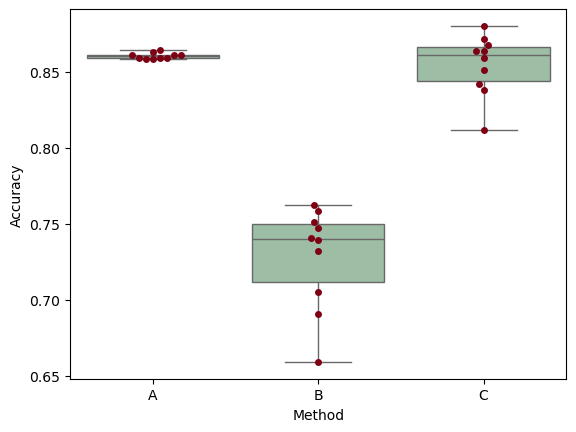

In [60]:
ax = sns.boxplot(x='Method', y='Accuracy', data=ej4_t, color='#99c2a2')
ax = sns.swarmplot(x='Method', y='Accuracy', data=ej4_t, color='#7d0013')
plt.show()

In [61]:
# Clasificador A
s, p = shapiro(ejer2['RegA'])
print('### Shapiro-Wilk normality test for classifier A')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))
# Clasificador B
s, p = shapiro(ejer2['RegB'])
print('### Shapiro-Wilk normality test for classifier B')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))
# Clasificador C
s, p = shapiro(ejer2['RegC'])
print('### Shapiro-Wilk normality test for classifier C')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

s, p = shapiro(ejer2['RegD'])
print('### Shapiro-Wilk normality test for classifier D')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))


### Shapiro-Wilk normality test for classifier A
### statistic = 0.6711, p-value = 0.0007
### Shapiro-Wilk normality test for classifier B
### statistic = 0.9608, p-value = 0.8062
### Shapiro-Wilk normality test for classifier C
### statistic = 0.8346, p-value = 0.0503
### Shapiro-Wilk normality test for classifier D
### statistic = 0.9716, p-value = 0.9081


In [62]:
spher, W, chisq, dof, pval = pg.sphericity(
    data       = ejer2_t,
    dv         = 'Accuracy',
    within     = 'Method',
    subject    = 'Dataset',
    method     = 'mauchly',
    alpha      = 0.05
)
print('Sphericity: {}, statistic: {:.3f}, chi-square-statistic: {:.3f}, degrees-of-freedom: {}, p-value: {:.3f}'.format(
    spher, W, chisq, dof, pval
))

Sphericity: True, statistic: 0.267, chi-square-statistic: 8.880, degrees-of-freedom: 5, p-value: 0.117


Como se puede deducir de los datos, las precisiones obtenidas por cada clasificador en cada uno de los conjuntos de datos no proceden de una distribución normal con un 95% de confianza (WClassA= 0.6711, p-valueClassA= 0.0007, WClassB= 0.9608, p-valueClassB = 0.8062, WClassC= 0.8346, p-valueClassC=0.0503, WClassD= 0.9716, p-valueClassD=0.9081 ). 

Como podemos ver la muestra obtenida para el clasificador RegA no cumple la normalidad (WClassA = 0.6711, p-value= 0.0007 < 0.05) ni RegC ( WClassC= 0.8346, p-valueClassC=0.0503 < 0.05)  con lo que debemos proceder a aplicar el test de Friedman. En el caso del test ANOVA de una vía para medidas pareadas se comprueba si las medias entre los diferentes clasificadores son iguales, es decir:

$$ H0: \eta_1 = \eta_2 = \dots = \eta_n $$
$$ H1: \text{las medianas no son iguales} $$


In [51]:
s, p = friedmanchisquare(ejer2['RegA'], ejer2['RegB'], ejer2['RegC'],ejer2['RegD'])
print('### Friedman rank sum test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Friedman rank sum test
### statistic = 9.2667, p-value = 0.0259


Como podemos observar, podemos afirmar con una del 95% que existen diferencias significativas en los índices Kappas obtenidos por los tres clasificadores en los conjuntos de datos utilizados (F= 9.2667,, p-value= 0.0259 < 0.05 ). Una vez confirmado la existencia de diferencias entre los clasificadores, tenemos que aplicar el test post hoc de Nemenyi para localizar dónde se encuentran dichas diferencias.


In [52]:
data = np.array([ejer2['RegA'], ejer2['RegB'], ejer2['RegC'],ejer2['RegD']])
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2,3
0,1.000000,0.261221,0.900000,0.670273
1,0.261221,1.000000,0.125527,0.018319
2,0.900000,0.125527,1.000000,0.875232
3,0.670273,0.018319,0.875232,1.000000


Como se puede obsercar hay similitud entre RegA , RegC y RegD  pero no con RegB

In [56]:
s, p = friedmanchisquare(ejer2['RegA'], ejer2['RegC'],ejer2['RegD'])
print('### Friedman rank sum test')
print('### statistic = {:.4f}, p-value = {:.4f}'.format(s, p))

### Friedman rank sum test
### statistic = 2.0000, p-value = 0.3679
